In [27]:
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.axes as ax
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

In [26]:
#!pip install shap
import shap

In [3]:
# connect with drive if needed
# from google.colab import drive
# drive.mount('/content/drive/')

## Decide for which model the decision should be made

In [5]:
# root_dir needs to set to correct directory where all the data, models, and shap_values are stored
root_dir = "" 
# model "original-keras1.h5" was used as original model but trained in keras 1 => used for all explanations
# model "without_temp.h5" was used to validate adaptations of the original model without the most significant feature (temperature of the gyroscope)
# model "without_gy.h5" was used to validate adaptations of the original model without the least significant feature for predictions above 5km/h
name = "original-keras1.h5"

### Load trained model

In [7]:
model = load_model(root_dir + "models/" + name) #n8 is the keras 1 model with my train_data (not shuffled)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 250, 32)           5120      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14529 (56.75 KB)
Trainable params: 14529 (56.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Load data

In [9]:
# for this test data the train mean was already substracted and it was devided to the training data std to approximately
# normalize the data with known values
# the data frames only contain unseen test data

# mess_sys1 = labels set from gps
mess_sys1 = pd.read_csv(root_dir + "data/" + "mess_sys1_data")

# mess_sys2 = input values of gyro and acc
# ACC_X_2 	ACC_Y_2 	ACC_Z_2 	GYRO_X_2 	GYRO_Y_2 	GYRO_Z_2 	GYRO_TEMP
mess_sys2 = pd.read_csv(root_dir + "data/" + "mess_sys2_data")

In [11]:
# dependent on which model you are using please only use the features that were used for the model
# for patrick-keras1-current.h5: ['ACC_X_2', 'ACC_Y_2', 'ACC_Z_2', 'GYRO_X_2', 'GYRO_Y_2', 'GYRO_Z_2', 'GYRO_TEMP']
# for without_temp.h5: ['ACC_X_2', 'ACC_Y_2', 'ACC_Z_2', 'GYRO_X_2', 'GYRO_Y_2', 'GYRO_Z_2']
# for without_gy: ['ACC_X_2', 'ACC_Y_2', 'ACC_Z_2', 'GYRO_X_2', 'GYRO_Z_2', 'GYRO_TEMP']
mess_sys2 = mess_sys2.loc[:,['ACC_X_2', 'ACC_Y_2', 'ACC_Z_2',
       'GYRO_X_2', 'GYRO_Y_2', 'GYRO_Z_2', 'GYRO_TEMP']]

In [12]:
train = 0.60
val = 0.16
test = 0.24
batchsize = 256

idx_val = round(train*len(mess_sys1)) #index of start val
idx_test = round((train+val)*len(mess_sys1)) #index of start test

idx_val = round(idx_val/batchsize)*batchsize
idx_test = round(idx_test/batchsize)*batchsize

# Machine Learning Part and Explainable AI

## The following the cells were used to evaluate each model
(for the results of the explanations please use the original model with keras 1 version)

#### Prepairing data as Timeseries object

In [14]:
dt_mess2 = 2 #Measurements every 10 ms = 100 Hz
dt_mess1 = 2
dt_target = 5 #Timeintervall for training

# use Timeseries Generator to prepaire the data
timesteps = 250 # set to 22 sec(22*0.05s = 1.1s) ; unqueal to 20 to be able to differentiate from features.shape

step = 2 # Versatz zum nächsten Sample; ungerade damit Interpolierte und urspüngliche Werte abwechselnd in die jeweilige LSTM-Zelle eingehen.

gen_train = TimeseriesGenerator(mess_sys2.to_numpy(), mess_sys1.to_numpy(), length=timesteps, stride=step, start_index=0, end_index=idx_val,
    shuffle=True, reverse=False, batch_size=batchsize)

gen_test = TimeseriesGenerator(mess_sys2.to_numpy(), mess_sys1.to_numpy(), length=timesteps, stride=1, start_index=idx_test, end_index=None,
    shuffle=False, reverse=False, batch_size=batchsize)

#### Predictions on the unseen test data

In [15]:
predictions = model.predict(gen_test)#, batch_size=batchsize)
#predictions = predictions[:len(predictions)//2]
y_real = gen_test.targets[(idx_test+timesteps):(idx_test+len(predictions)+timesteps)]
x_real = gen_test.data[gen_test.start_index:]


c:\users\danie\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [16]:
mess_sys2.columns

Index(['ACC_X_2', 'ACC_Y_2', 'ACC_Z_2', 'GYRO_X_2', 'GYRO_Y_2', 'GYRO_Z_2',
       'GYRO_TEMP'],
      dtype='object')

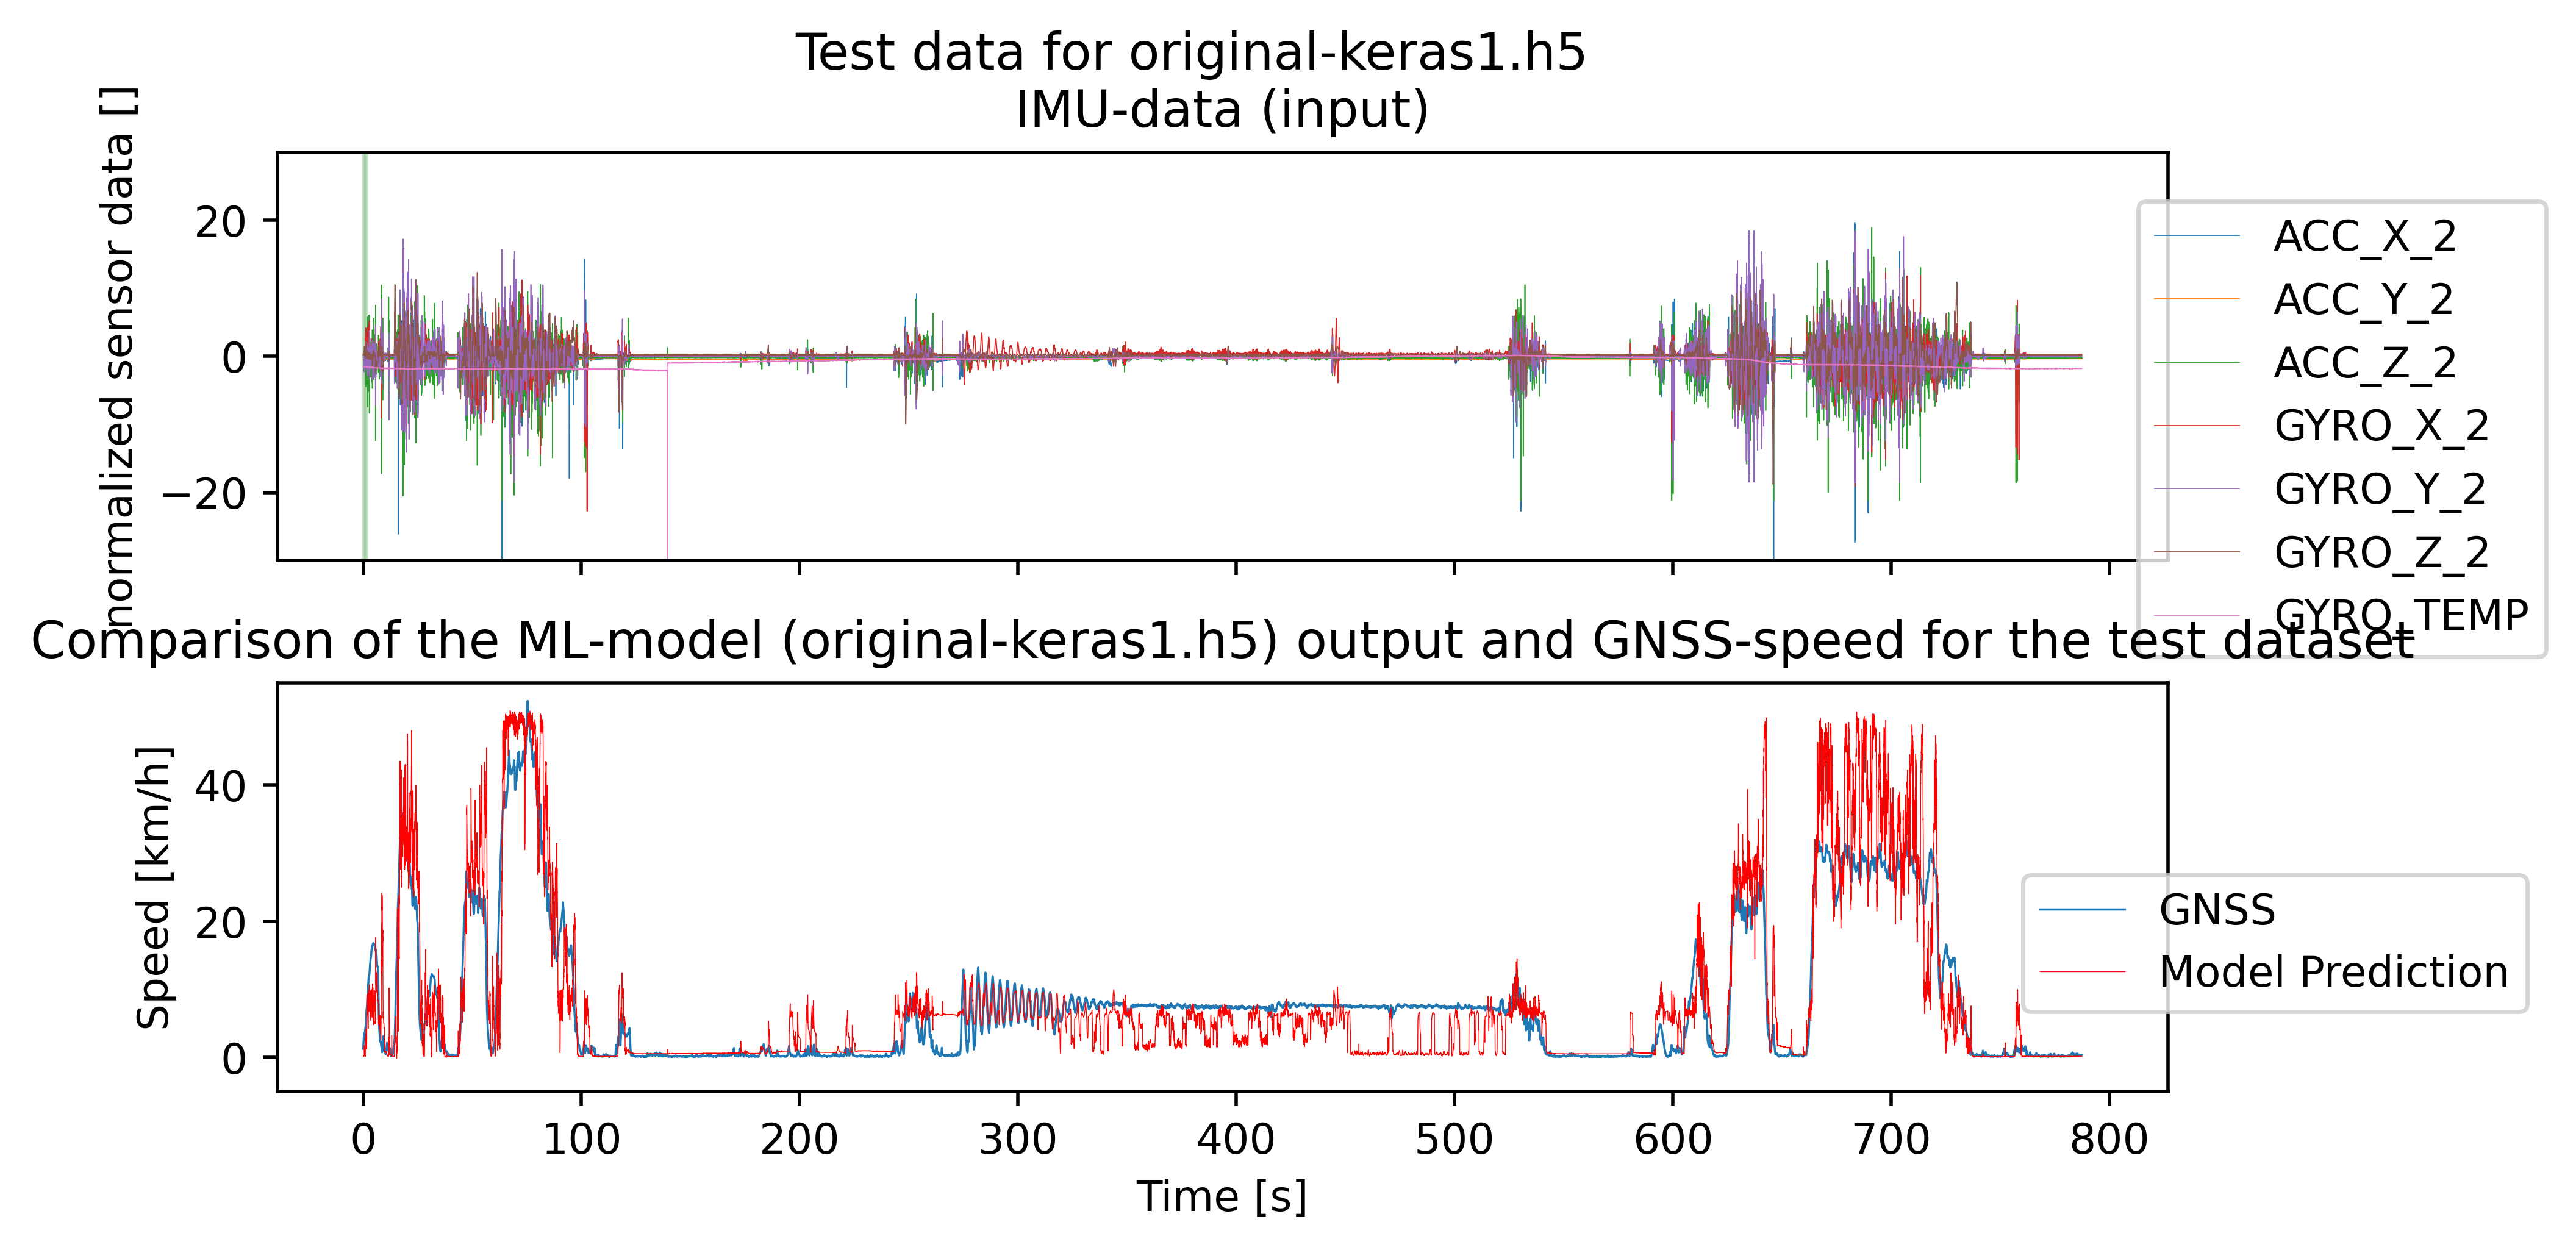

In [17]:
f, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4), dpi=500, facecolor='w', edgecolor='k')
ax2.plot(np.linspace(0,len(predictions)*dt_target/1000-dt_target/1000,len(predictions)), y_real, label="GNSS", linewidth=0.5)
ax2.plot(np.linspace(0,len(predictions)*dt_target/1000-dt_target/1000,len(predictions)), predictions,'r', label="Model Prediction", linewidth=0.2)

for i in range(x_real.shape[1]):
    ax1.plot(np.linspace(0,len(predictions)*dt_target/1000-dt_target/1000,len(predictions)), x_real[:,i], label=mess_sys2.columns[i], linewidth=0.25)    # x_real[:,i] oder x_real[:,i]*std[i]+mean[i]
ax1.legend(bbox_to_anchor=(1, 0.5, 0.2, 0.38), borderaxespad=0)
ax1.xaxis.set_ticklabels([])
ax1.set(title='IMU-data (input)', ylabel='normalized sensor data []')
#ax1.yaxis.set_ticks([-30, 0, 30])
ax1.fill_betweenx([-30,30],0,1.25,color='g', alpha=0.2)
ax1.set_ybound(lower=-30, upper=30)

ax2.set(title='Comparison of the ML-model (' +name +') output and GNSS-speed for the test dataset',xlabel='Time [s]', ylabel='Speed [km/h]')
ax2.legend(bbox_to_anchor=(1, 0.15, 0.19, 0.38), borderaxespad=0)

f.suptitle('Test data for ' +name)
f.subplots_adjust(hspace=0.3)

# ax2.fill_betweenx([-5,55],-3,100,color='g', alpha=0.2)
#ax2.fill_betweenx([-5,55],35,36,color='b', alpha=1)
#ax2.fill_betweenx([-5,55],75,100,color='y', alpha=0.1)


#plt.xlim(left=140, right=220)
#plt.xlim(left=150, right=200)
plt.ylim(bottom=-5, top=55)
plt.show()

In [18]:
import numpy as np

# Assuming you have predictions and y_real arrays

# Create a boolean mask for values where y_real > 5
mask_gt_5 = y_real > 5

# Create a boolean mask for values where y_real <= 5
mask_leq_5 = y_real <= 5

# Filter predictions based on the masks
predictions_gt_5 = predictions[mask_gt_5]
predictions_leq_5 = predictions[mask_leq_5]

# Filter y_real based on the masks
y_real_gt_5 = y_real[mask_gt_5]
y_real_leq_5 = y_real[mask_leq_5]

# Calculate absolute errors for each subset
error_gt_5 = np.abs(predictions_gt_5 - y_real_gt_5)
error_leq_5 = np.abs(predictions_leq_5 - y_real_leq_5)
mean_error_total = np.mean(np.abs(predictions - y_real))

# Print or use the errors as needed
print("Errors for y_real > 5:", np.mean(error_gt_5))
print("Errors for y_real <= 5:", np.mean(error_leq_5))
print("Total Error mean: ", mean_error_total)

Errors for y_real > 5: 4.814292127107328
Errors for y_real <= 5: 1.4443688504397536
Total Error mean:  3.2878433592268124


All:
Errors for y_real > 5: 4.814292124357752
Errors for y_real <= 5: 1.4443688505989434
Total Error mean:  3.2878433577947983

Without Gyr Y:
Errors for y_real > 5: 4.841973368391976
Errors for y_real <= 5: 1.7687070655658548
Total Error mean:  3.449899075841131

Without Temp:
Errors for y_real > 5: 3.6180927962023843
Errors for y_real <= 5: 2.6886265542384904
Total Error mean:  3.197079472351488

Without Z and Y:
Errors for y_real > 5: 10.007822671065007
Errors for y_real <= 5: 1.1724081989241697
Total Error mean:  6.005711516757128


# Explaining the LSTM Model with SHAP DeepExplainer
(make sure to use the original model for the predictions above to receive correct results)

In [19]:
def get_batch_shap_values(explainer, index):
  batch = 616-((157470-index)/256)
  position = int(256*(batch-int(batch)))
  batch_str = str(batch)
  try:
    second_position = int(batch_str[batch_str.index('.') + 2])
  except:
    second_position = 0
  try:
    return explainer.shap_values(gen_test[int(batch)][0][position:(position+24)])[0][second_position]
  except:
    return explainer.shap_values(gen_test[int(batch)][0][position:(position+24)])[0][-1]

## Explaining the worst Predictions


In [20]:
# getting indices of predictions with errors greater than 35
x = np.where((predictions-y_real) > 35)
x[0]

array([ 11309, 128529, 128530, 128531, 128532, 128533, 128534, 128535,
       128536, 128537, 128538, 128539, 128540, 128541, 128542, 128543,
       128544, 128545, 128546, 128547, 128548, 128549, 128550, 128551,
       128552, 128553, 128554, 128555, 128556, 128557, 128558, 128559,
       128560, 128561, 128562, 128563, 128564, 128565, 128566, 128567,
       128568, 128569, 128570, 128571, 128572, 128573, 128574, 128575,
       128576, 128577, 128578, 128579], dtype=int64)

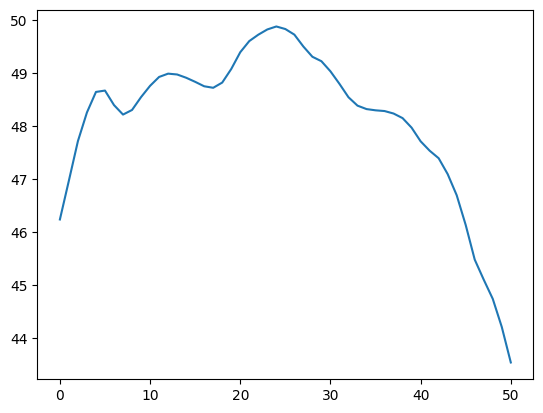

In [21]:
# plot the predictions for the consecutive sequence of bad predictions
plt.plot(predictions[128529:128580])

The max error occuring in the test set:  40.75295913696289


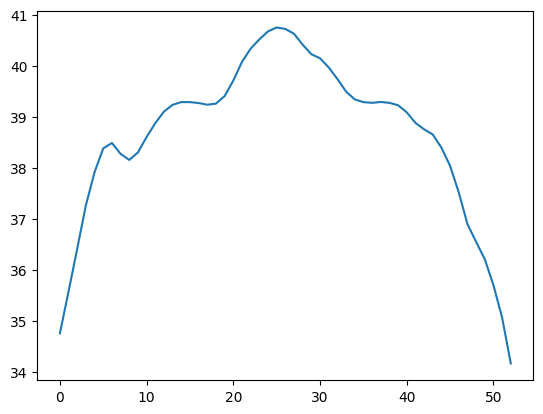

In [22]:
# in the range of [11300:11320] an error=36 occurs
# in the range of [128000:129000] (error=40), [128529:128580] (consecutive sequence with multiple errors > 35)
print("The max error occuring in the test set: ", max(predictions-y_real)[0])
plt.plot((predictions-y_real)[128528:128581])

In [23]:
# just some calculations to check where those predictions are (in which batch)
#256*250*616, len(predictions), 256*250*616/len(predictions),

# calculating the batch an position of the mispredictions
616-((157470-128500)/256), 616-((157470-11300)/256)

(502.8359375, 45.0234375)

In [28]:
# second highest spot with 36 and outside of sequence! (at batch 45 at position 0.023*256)
explainer = shap.DeepExplainer(model, gen_train[45][0])
shap_values = explainer.shap_values(gen_test[45][0][:int(256*0.1)]) # results in 25 shap values

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [29]:
# plot the shapley values for the misprediction of 36 (outside of the sequence of mispredictions) over all lag values (please order by original sample ordering)
shap.initjs()
# index 5 or 6 should be the misprediction => are similar
shap.force_plot(explainer.expected_value[0], shap_values[0][5], mess_sys2.columns)

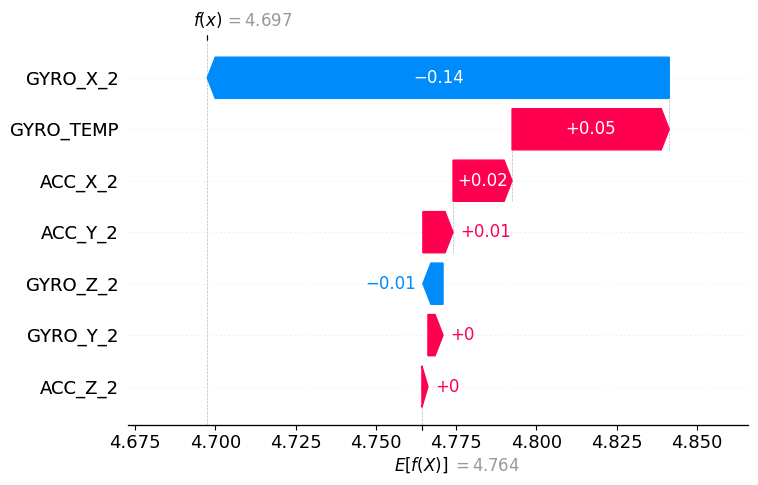

In [30]:
# plotting the shapley values for the last lag value t-1 = [249]
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0][5][249],
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)

In [31]:
# summing up all shaple value over all lag values for each feature to check their total contribution
summed_up_shaps_time_second_highest = np.sum(shap_values[0], axis=1, keepdims=True)
summed_up_shaps_time_second_highest.shape

(25, 1, 7)

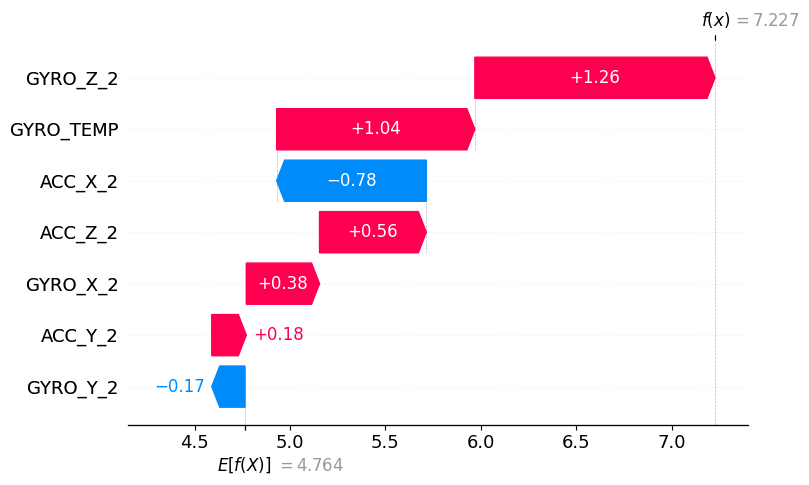

In [32]:
# plotting the total contribution
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       summed_up_shaps_time_second_highest[4][0],
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)

In [33]:
# explainer (explainer does not need to be new calculated since it is depend on training data and not on test data => explanations and expectations are similar for all batches)
# and shap values for the highest error sequence, same plots as for the second highest error (outside of the sequence)
explainer = shap.DeepExplainer(model, gen_train[502][0])
shap_values_higest_seq = explainer.shap_values(gen_test[502][0][int(256*0.8):])

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_higest_seq[0][7], mess_sys2.columns)

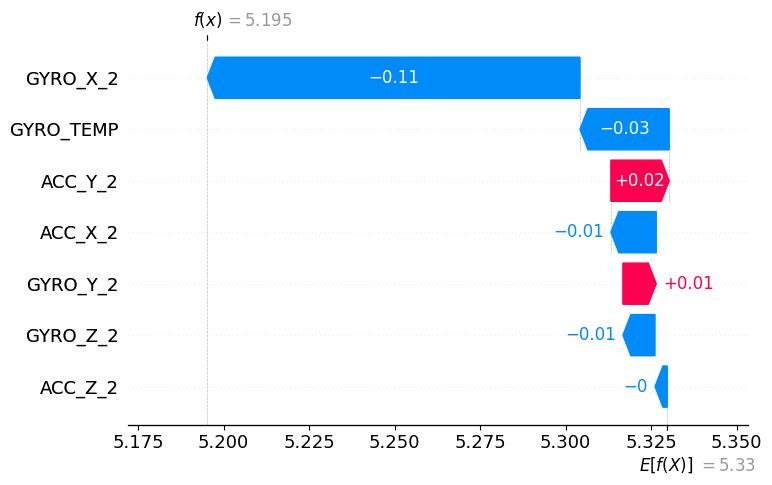

In [35]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values_higest_seq[0][7][249],
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)

In [36]:
summed_up_shaps_time = np.sum(shap_values_higest_seq[0], axis=1, keepdims=True)
summed_up_shaps_time.shape

(52, 1, 7)

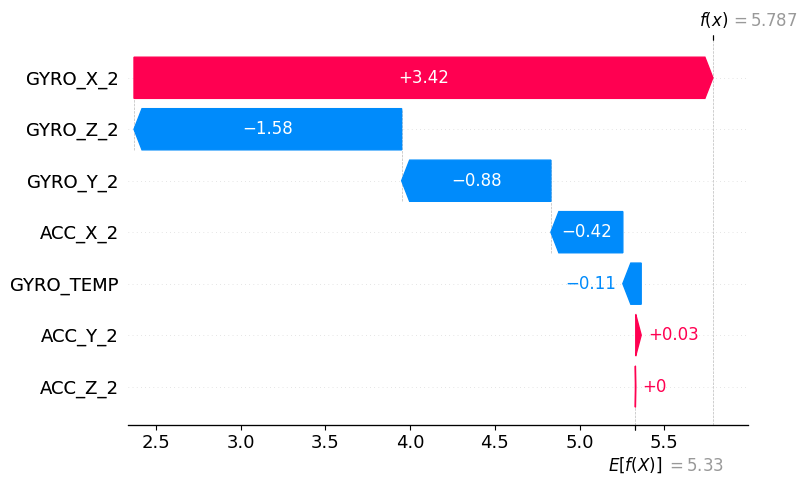

In [37]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       summed_up_shaps_time[7][0],
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)

In [38]:
# checking minimum and maximum feature contributions in the consecutive time sequence
np.min(summed_up_shaps_time, axis=0), np.max(summed_up_shaps_time, axis=0)

(array([[-0.64671883,  0.00282788, -0.06409114,  1.90906492, -1.20847354,
         -1.75297536, -0.27729892]]),
 array([[ 0.96131114,  0.10444656,  0.98401267,  4.13524402, -0.45461704,
         -0.83665398,  0.64265041]]))

## Explaining the Best Predictions

In [39]:
# get all predictions where the error is below a threshold
x_best = np.where((predictions-y_real) < 0.1)
# print amount of prediction errors below 0.1
print("Amount of prediction erros below 0.1 km/h: ", np.sum((predictions-y_real) < 0.1), "these are ", (np.sum((predictions-y_real) < 0.1)/len(predictions)*100), "% of the total test data.")
# get all good predictions that are not 0
best_predictions = predictions[x_best[0]]
print("Relative amount of predictions > 5km/h: ", np.sum(best_predictions > 5)/len(best_predictions))

# let's split both lists up into indices with perfect prediction
# with predictions > 5:
x_best_g5 = np.where(best_predictions > 5)[0]
x_best_l5 = np.where(best_predictions < 5)[0]

Amount of prediction erros below 0.1 km/h:  79551 these are  50.51819394170318 % of the total test data.
Relative amount of predictions > 5km/h:  0.43575819285741224


In [40]:
# getting some random samples (indices)
random_50_best_g5 = np.random.choice(x_best_g5, size=30)
random_50_best_l5 = np.random.choice(x_best_l5, size=20)
shaps_best_g5 = []
shaps_best_l5 = []

In [41]:
# calculating shaps for the random samples
for i in range(len(random_50_best_g5)):
  if i % 5 == 0: print(i)
  shaps_best_g5.append(get_batch_shap_values(explainer, random_50_best_g5[i]))

0
5
10
15
20
25


In [42]:
np.mean(np.array(shaps_best_g5), axis=0).shape

(250, 7)

In [43]:
# checked some individual plots, the plot now corresponds to the mean of the 30 chosen samples
mean_best_g5 = np.mean(np.array(shaps_best_g5), axis=0)
shap.initjs()
shap.force_plot(explainer.expected_value[0], mean_best_g5, mess_sys2.columns)

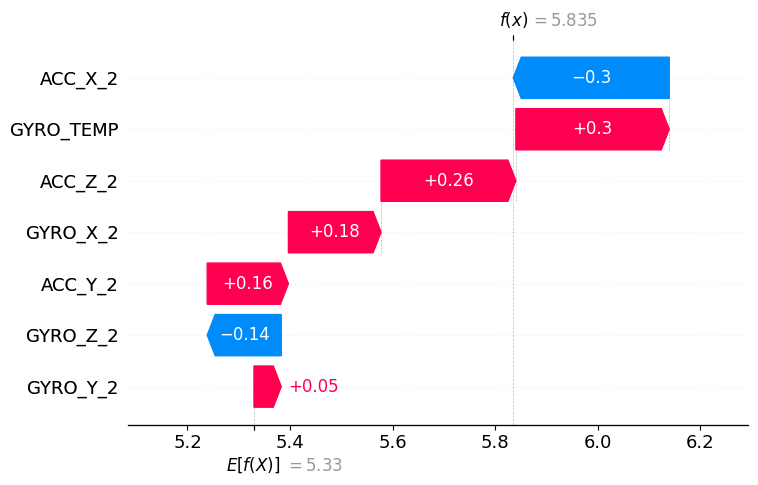

In [44]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       np.sum(mean_best_g5, axis=0),
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)

In [45]:
for i in range(len(random_50_best_l5)):
  if i % 5 == 0: print(i)
  shaps_best_l5.append(get_batch_shap_values(explainer, random_50_best_l5[i]))

0
5
10
15


In [46]:
mean_best_l5 = np.mean(np.array(shaps_best_l5), axis=0)
shap.initjs()
shap.force_plot(explainer.expected_value[0], mean_best_l5, mess_sys2.columns)

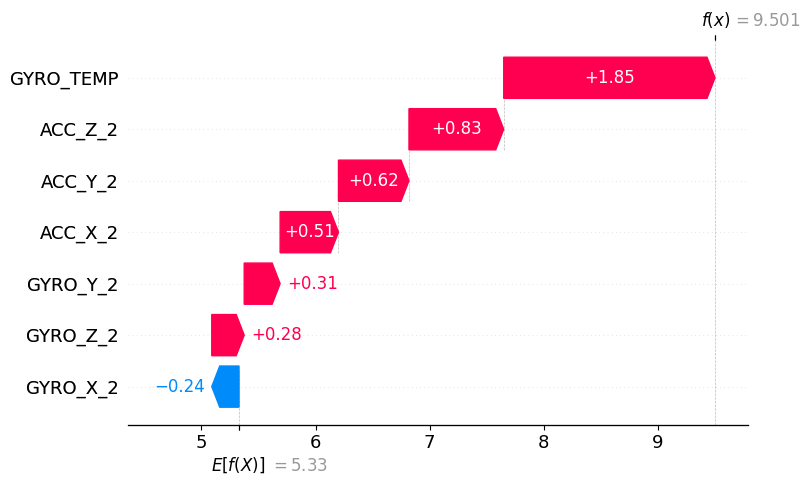

In [47]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       np.sum(mean_best_l5, axis=0),
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)

## Global Shap

In [48]:
explainer = shap.DeepExplainer(model, gen_train[522][0])

### Loading earlier calculated random shap values

In [50]:
shap_values_1 = np.load(root_dir + "shap_values/" + "shap_val_15_random.npy")
batches_1 = [522, 576, 578, 328, 558, 545, 325, 232, 473, 92, 443, 151, 27, 139, 200]
shap_values_1.shape

(3840, 250, 7)

In [51]:
shap_values_2 = np.load(root_dir + "shap_values/" + "shap_val_15_2_random.npy")
batches_2 = [490,  11, 119, 549,  78,  50, 168, 338, 500, 197, 582, 432, 397, 391, 420]
shap_values_2.shape

(3840, 250, 7)

In [52]:
shap_values_global = np.concatenate((shap_values_1, shap_values_2), axis=0)
shap_values_global.shape

(7680, 250, 7)

In [53]:
# calculate the mean over all shap values
mean = np.mean(shap_values_global, axis=0)
mean.shape

(250, 7)

In [54]:
# produce mean shap values force_plot for global explanation for each lag value
shap.initjs()
shap.force_plot(explainer.expected_value[0], mean, mess_sys2.columns)

In [56]:
p = np.sum(mean[:160], axis=0)/np.sum(mean, axis=0)
p
# check mean total contribution before t-80 = 160
# ACC_X_2 	ACC_Y_2 	ACC_Z_2 	GYRO_X_2 	GYRO_Y_2 	GYRO_Z_2 	GYRO_TEMP

array([0.33841484, 0.09243818, 0.20167129, 0.41573518, 0.2273724 ,
       0.28365256, 0.23590958])

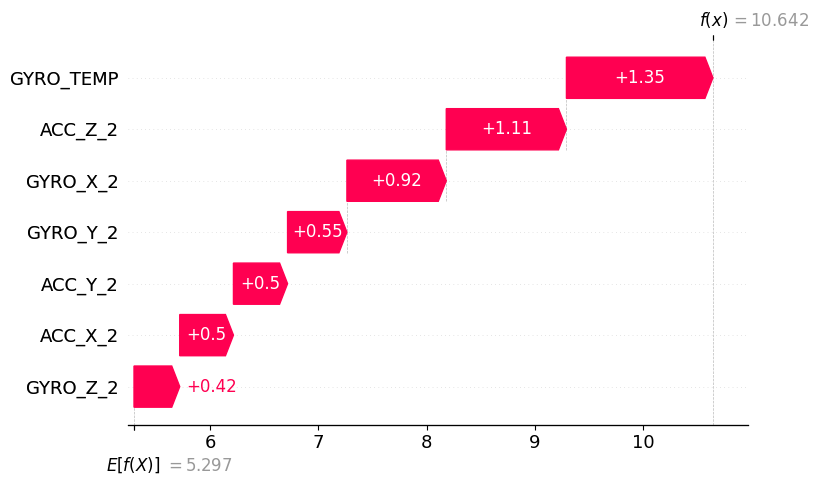

In [58]:
# plot mean total contribution as sum over all lag values
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       np.sum(mean, axis=0),
                                       feature_names = mess_sys2.columns,
                                       show = True,
                                       max_display=12)